Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
STUDENT_ID = ""

---

# MTH793P - Coursework 2

This is a template notebook for the computational exercises of Coursework #2 of the module MTH793P, Advanced Machine Learning. Closely follow the instructions in this template in order to complete the assessment and to obtain full marks. Please only modify cells where you are instructed to do so. Failure to comply may result in unexpected errors that can lead to mark deductions.

As usual, we begin by loading the necessary libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons

With the following cell, we generate samples from a dataset known as 'Two moons'. We will later try to identify from which half-moon a sample originates in a fully unsupervised fashion. We store *no_of_samples* samples in a matrix *X* and the corresponding labels in a vector *y*. We visualise the dataset with PyPlot.

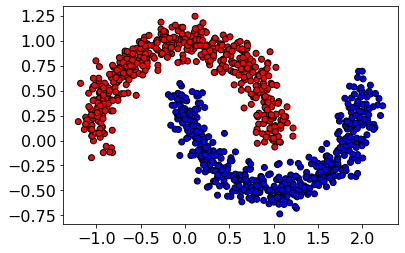

In [3]:
seed = 13
np.random.seed(seed)
no_of_samples = 1000
X, y = make_moons(n_samples=no_of_samples, noise=0.1, random_state=seed)
colormap_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colormap_bright, edgecolors='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

In order to do so, we will built a weighted graph with weights based on the pairwise Euclidean distances between samples. For this, we write a function **pairwise_distances** that takes two arguments *argument1* and *argument2* that are NumPy arrays for which the first dimension equals the number of samples and the second dimension the dimension of each sample. The function should return the pairwise Euclidean distances between the points in the arrays. You can make use of any of the pairwise-distance functions that you have already implemented in MTH786P.

In [4]:
def pairwise_distances(argument1, argument2):
    # newaxis expands array around an axis to create a new matrix
    return np.sqrt(np.sum((argument1[:,np.newaxis,:]-argument2[np.newaxis,:,:])**2, axis=2))
#raise NotImplementedError()

Use your function *pairwise_distances* to compute the pairwise distances between *X* and *X* itself and store these distances in an array named *distance_matrix*. 

In [5]:
distance_matrix = pairwise_distances(X, X)
#raise NotImplementedError()
# Each row gives distance between each data point and each other data point

Use these pairwise distances to compute the weights *graph_weights* of your graph via the equation

$$ \text{graph_weights}_{ij} = \begin{cases} \exp(-\gamma \| x_i - x_j \|) & \exp(-\gamma \| x_i - x_j \|) \geq \tau \\ 0 & \text{otherwise} \end{cases} \, , $$

for $i, j \in \{1, \ldots, \text{no_of_samples}\}$. Here $\gamma$ and $\tau$ are positive constants that control the sparsity of the graph. Write a function **create_graph_weights** that takes three arguments *distance_matrix*, *gamma* and *tau* and returns an argument *graph_weights*.

In [ ]:
def create_graph_weights(distance_matrix, gamma, tau):
    weight_graph = np.where(np.exp(-distance_matrix*gamma) >= tau,  np.exp(-distance_matrix*gamma), 0)
    return weight_graph
#raise NotImplementedError()

Create weights *graph_weights* based on your pairwise distances *distance_matrix* for choices $\gamma = 3.5$ and $\tau = 10^{-1}$.

In [108]:
gamma = 3.5
tau = 0.1
weights = create_graph_weights(distance_matrix, gamma, tau)
#raise NotImplementedError()

The following cell tests your code for test specific choices of *gamma* and *tau*.

In [109]:
from numpy.testing import assert_array_almost_equal
test_matrix = X[[70, 320, 785], :]
test_weights = create_graph_weights(pairwise_distances(test_matrix, test_matrix), 1.5, tau)
assert_array_almost_equal(test_weights, [[1, 0, 0.18847515], [0, 1, 0.23472212], [0.18847515, 0.23472212,1]])

Next, we use the graph weights to compute the incidence matrix of the graph. For this we modify the function **construct_incidence_matrix** from Coursework as follows: instead of  the argument *nodes* the modified version takes the argument *no_of_nodes*. Note that the function allows entries of *weights* to be zero, resulting in some rows of the incidence matrix to be zero. All zero rows should therefore be removed before the incidence matrix is returned. How do you identify the row-indices for which the rows are zero? Use your favourite search engine or the SciPy help.

In [110]:
# Don't want to include edges to own node or to include edges twice
def construct_incidence_matrix(no_of_nodes, edges, weights):
    incidence_matrix = np.zeros((len(edges), no_of_nodes))
    for n1 in range(no_of_nodes):
        for n2 in range(no_of_nodes):
            if(n1 < n2):
                incidence_matrix[n1][edges[n1][n2][0]] = -np.sqrt(weights[n1][n2])
                incidence_matrix[n1][edges[n1][n2][1]] = np.sqrt(weights[n1][n2])
    incidence_matrix = incidence_matrix[~np.all(incidence_matrix == 0, axis=1)]
    return incidence_matrix
    #raise NotImplementedError()

Define a list *edges* of edges between all nodes that matches the order to the weights *graph_weights* defined earlier.

In [111]:
# 2D list containing [i,j] indices between vertices
edges = [[[k,i] for i, j_val in enumerate(distance_matrix[0])] for k, l_val in enumerate(distance_matrix)]
#raise NotImplementedError()

Construct the incidence matrix *incidence_matrix* via **construct_incidence_matrix** for your edges *edges* and weights *graph_weights*. The number of nodes should match the number of samples *no_of_samples*.

In [112]:
construct_incidence_matrix(no_of_samples, edges, weights)
#raise NotImplementedError()

array([[-0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.78665797, ...,  0.        ,
         0.        ,  0.78665797],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         0.58346848,  0.        ]])

Define the corresponding graph-Laplacian and store it in a variable named *graph_laplacian*.

In [113]:
def laplacian(no_of_nodes, edges, weights):
    laplacian_matrix = np.zeros((no_of_nodes, no_of_nodes))
    w = 0
    diagonals = [0]*no_of_nodes
    for n1 in range(no_of_nodes):
        for n2 in range(no_of_nodes):
            if(n1 < n2):
                laplacian_matrix[n1][n2] = - weights[n1][n2]
                laplacian_matrix[n2][n1] = - weights[n1][n2]
                diagonals[n1] += weights[n1][n2]
                diagonals[n2] += weights[n1][n2]
    for n in range(no_of_nodes):
        laplacian_matrix[n][n] = diagonals[n]
    return laplacian_matrix
graph_laplacian = laplacian(no_of_samples, edges, weights)
#raise NotImplementedError()

The graph_laplacian has 208440 non-zero out of 1000000 entries.


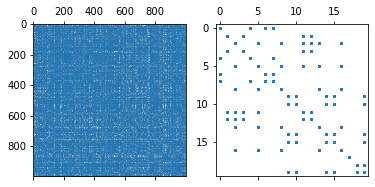

In [114]:
print('The graph_laplacian has {nz} non-zero out of {t} entries.'.format(nz=np.count_nonzero( \
        graph_laplacian), t=no_of_samples ** 2))
plt.subplot(1, 2, 1)
plt.spy(graph_laplacian, markersize=0.05)
plt.subplot(1, 2, 2)
plt.spy(graph_laplacian[:20, :20], markersize=2)
plt.tight_layout;

Compute the first two smallest eigenvalues and corresponding eigenvectors and store them in the variables *eigenvalues* and, respectively, *eigenvectors*.

In [115]:
eigen_vals_vecs = linalg.eigs(graph_laplacian, 2, which = "SM")

# Smallest
print(eigen_vals_vecs[0][0])
print(eigen_vals_vecs[1][:,0])

# Second smallest
print(eigen_vals_vecs[0][1])
print(eigen_vals_vecs[1][:,1])

eigenvalues = eigen_vals_vecs[0]
second_smallest_eigenvector = eigen_vals_vecs[1][:,1]
#raise NotImplementedError()

(1.509903313490213e-14+0j)
[-0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j
 -0.03162278+0.j -0.03162278+0.j -0.03162278+0.j -0.03162278+0.

In [116]:
assert_array_almost_equal(eigenvalues, [0, 1.604139355])
print('The two smallest eigenvalues of the graph-Laplacian are λ0 = {l0:.4f} and λ1 = {l1:.4f}.'.format( \
        l0=eigenvalues[0].real, l1=eigenvalues[1].real))

The two smallest eigenvalues of the graph-Laplacian are λ0 = 0.0000 and λ1 = 1.6041.


Use the second eigenvector to create a Boolean vector *unsupervised_labels* for visualisation of the two moons dataset. What do you observe? How could results be improved?

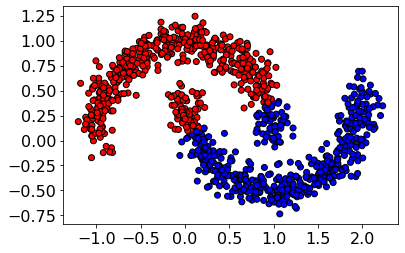

In [118]:
unsupervised_labels = np.full((no_of_samples, 1), False)
unsupervised_labels[second_smallest_eigenvector >= 0] = True
#raise NotImplementedError()
plt.scatter(X[:, 0], X[:, 1], c=unsupervised_labels, cmap=colormap_bright, edgecolors='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

# Alter gamma and tau to improve

This concludes this week's coursework.